<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/10_Kalman_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



칼만필터로 시계열을 예측



RMSE (Observed vs True): 0.651
RMSE (Kalman vs True):   0.503


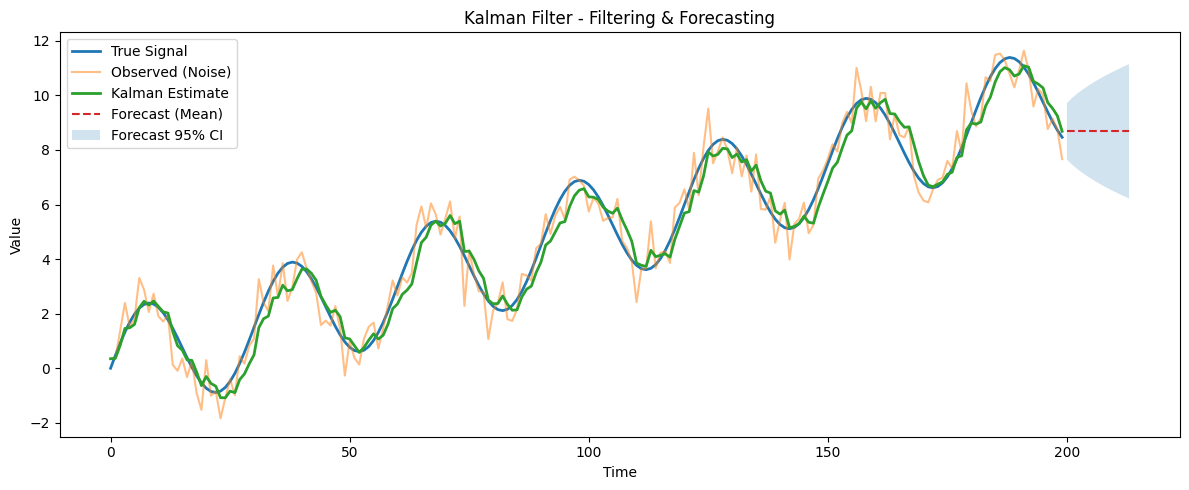

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) 예제 데이터 생성 (진짜 신호 + 관측잡음)
# -----------------------------
np.random.seed(42)

T = 200  # 전체 데이터 길이
# "진짜 신호": 완만한 추세 + 약한 계절성(사인파)
t = np.arange(T)
true_signal = 0.05 * t + 2.0 * np.sin(2 * np.pi * t / 30)

# 관측 노이즈 추가 -> 실제 관측되는 y
obs_noise_std = 0.7
y = true_signal + np.random.normal(0, obs_noise_std, size=T)

# -----------------------------
# 2) 로컬 레벨(Local Level) 칼만필터
#    상태식: x_t = x_{t-1} + w_t,   w_t ~ N(0, Q)
#    관측식: y_t = x_t     + v_t,   v_t ~ N(0, R)
# -----------------------------
Q = 0.1   # 시스템 잡음 공분산
R = 0.5   # 관측 잡음 공분산

# 초기 상태값 및 분산
x_hat = np.zeros(T)   # 상태 추정값
P = np.zeros(T)       # 상태 추정 분산
x_hat[0] = y[0]       # 초기 상태는 첫 관측값으로
P[0] = 1.0            # 초기 분산

# 예측값/칼만이득 저장
x_pred = np.zeros(T)   # 예측된 상태
P_pred = np.zeros(T)   # 예측 분산
K_gain = np.zeros(T)   # 칼만 이득

# 칼만필터 루프
for t_idx in range(1, T):
    # (1) 예측 단계
    x_pred[t_idx] = x_hat[t_idx-1]
    P_pred[t_idx] = P[t_idx-1] + Q

    # (2) 갱신 단계
    K_gain[t_idx] = P_pred[t_idx] / (P_pred[t_idx] + R)  # 칼만 이득
    innovation = y[t_idx] - x_pred[t_idx]                # 관측 오차
    x_hat[t_idx] = x_pred[t_idx] + K_gain[t_idx] * innovation
    P[t_idx] = (1 - K_gain[t_idx]) * P_pred[t_idx]

# -----------------------------
# 3) 성능 평가 (RMSE)
# -----------------------------
def rmse(a, b):
    return np.sqrt(np.mean((np.asarray(a) - np.asarray(b))**2))

rmse_obs = rmse(y, true_signal)       # 노이즈 관측 vs 진짜
rmse_kf  = rmse(x_hat, true_signal)   # 칼만 추정 vs 진짜

print(f"RMSE (Observed vs True): {rmse_obs:.3f}")
print(f"RMSE (Kalman vs True):   {rmse_kf:.3f}")

# -----------------------------
# 4) 미래 예측 (Forecasting)
# -----------------------------
H = 14  # 예측할 기간
forecast_mean = np.full(H, x_hat[-1])  # 마지막 상태를 기준으로 고정 예측
forecast_std = np.sqrt(P[-1] + np.arange(1, H+1) * Q)  # 불확실성 증가
fc_upper = forecast_mean + 1.96 * forecast_std
fc_lower = forecast_mean - 1.96 * forecast_std

# -----------------------------
# 5) 시각화
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(true_signal, label="True Signal", linewidth=2)
plt.plot(y, label="Observed (Noise)", alpha=0.5)
plt.plot(x_hat, label="Kalman Estimate", linewidth=2)

# 미래 예측 결과 표시
idx_future = np.arange(T, T+H)
plt.plot(idx_future, forecast_mean, "--", label="Forecast (Mean)")
plt.fill_between(idx_future, fc_lower, fc_upper, alpha=0.2, label="Forecast 95% CI")

plt.title("Kalman Filter - Filtering & Forecasting")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


# 칼만필터(상태공간모형)**로 테슬라(TSLA) 종가를 예측

[INFO] Train samples: 691, Test samples: 60
[INFO] Model fitted with Kalman Filter (UnobservedComponents).
[INFO] Kalman estimate plot skipped: 'UnobservedComponentsResults' object has no attribute 'level_smoothed'
Test MAE  : 12.6825
Test RMSE : 15.6833
Test MAPE : 3.85%


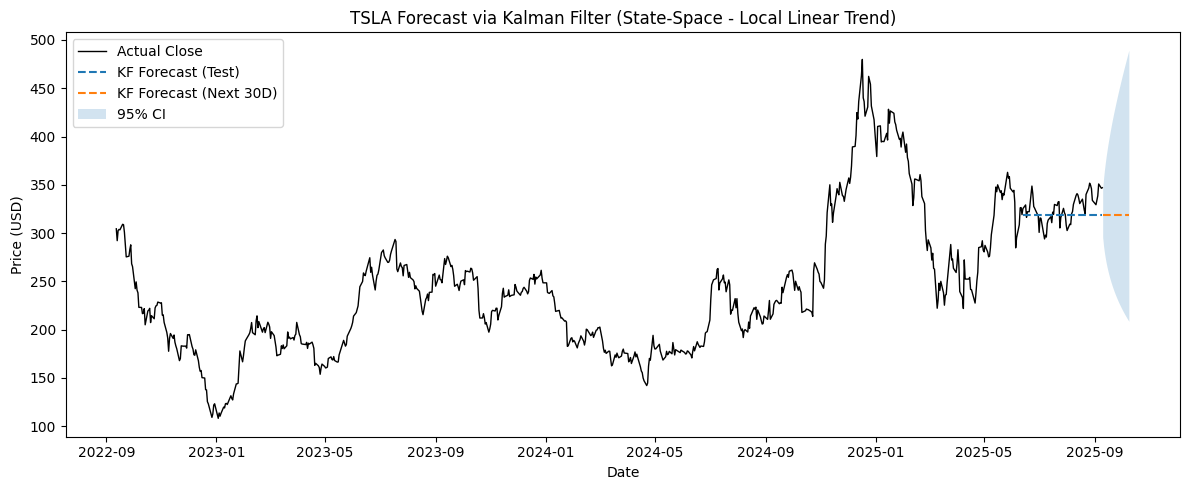

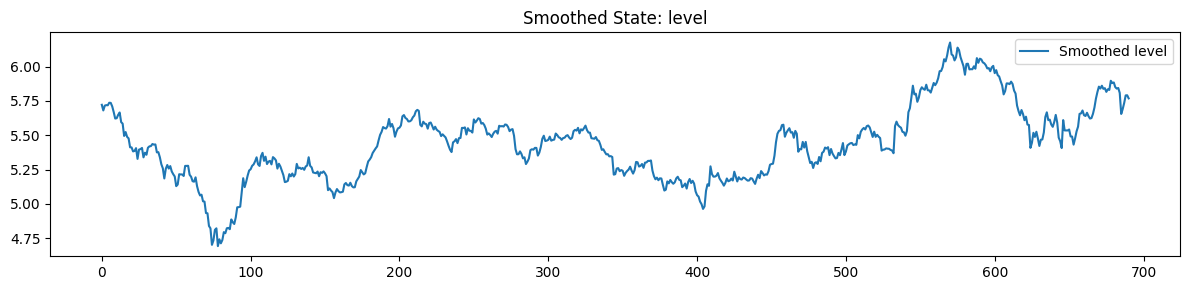

In [4]:
# -*- coding: utf-8 -*-
# -------------------------------------------------------------
# 테슬라(TSLA) 주가 예측 (Kalman Filter / State-Space Model)
# - 주석: 한국어
# - 출력: 영어
# -------------------------------------------------------------

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# yfinance 및 상태공간모형(칼만필터) 패키지
import yfinance as yf
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# 0) 유틸 함수
# -----------------------------
def safe_download_tsla(period="3y", interval="1d"):
    """yfinance 반환 형태(빈 DF, MultiIndex 등) 변동에 안전하게 TSLA 종가를 가져오는 함수"""
    df = yf.download("TSLA", period=period, interval=interval,
                     group_by="column", auto_adjust=False, actions=False, progress=False)
    if df is None or df.empty:
        raise RuntimeError("yfinance returned empty data. Check network/period/interval.")
    # Close 컬럼 탐색 (단일/복수 칼럼 방어)
    if isinstance(df.columns, pd.MultiIndex):
        flat = []
        for col in df.columns:
            name = "_".join([str(c) for c in col if c is not None])
            flat.append(name)
        df.columns = flat
        cand = [c for c in df.columns if c.lower().endswith("close")]
    else:
        cand = [c for c in df.columns if c.lower() == "close"]
    if not cand:
        # Ticker API 대체 루트
        alt = yf.Ticker("TSLA").history(period=period, interval=interval, auto_adjust=False)
        if alt is None or alt.empty or "Close" not in alt.columns:
            raise KeyError(f"Cannot find Close column. Current columns: {list(df.columns)}")
        out = alt[["Close"]].copy()
    else:
        out = df.rename(columns={cand[0]: "Close"})[["Close"]].copy()
    out = out.dropna()
    # Prophet/상태공간 등에 유리하게 tz 제거
    out.index = pd.to_datetime(out.index).tz_localize(None)
    return out

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    eps = 1e-12
    return float(np.mean(np.abs((y_true - y_pred) / (np.maximum(np.abs(y_true), eps)))) * 100.0)

# -----------------------------
# 1) 데이터 수집 및 전처리
# -----------------------------
# (한글) 최근 3년치 TSLA 종가 다운로드
df = safe_download_tsla(period="3y", interval="1d")

# (한글) 로그변환(안정화) 옵션
use_log = True
if use_log:
    df["y"] = np.log1p(df["Close"])  # log(1+Close)
else:
    df["y"] = df["Close"]

# (한글) 학습/평가 분할: 최근 60거래일을 테스트로 사용
test_size = 60
y = df["y"].copy()
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
close_train, close_test = df["Close"].iloc[:-test_size], df["Close"].iloc[-test_size:]

print(f"[INFO] Train samples: {len(y_train)}, Test samples: {len(y_test)}")

# -----------------------------
# 2) 상태공간모형 정의 (칼만필터 내부 사용)
#    - 로컬 선형 추세(Local Linear Trend)
# -----------------------------
model = UnobservedComponents(
    endog=y_train,
    level='llevel',      # 로컬 레벨
    trend=True,          # 로컬 트렌드(기울기) 포함
    seasonal=None        # 일단 계절성 미사용(주가는 비주기적)
)

# (한글) 모형 적합 (내부적으로 Kalman Filter로 상태/모수 추정)
res = model.fit(disp=False)
print("[INFO] Model fitted with Kalman Filter (UnobservedComponents).")

# -----------------------------
# 2A) Kalman Estimate(훈련 구간) 시각화 추가
# -----------------------------
# (한글) 로컬 선형 추세 모형에서 관측식은 y_t = level_t + epsilon_t 이므로
#        '평활된 레벨(smoothed level)'이 곧 칼만 추정 신호로 해석 가능.
try:
    # statsmodels는 level_smoothed를 제공(훈련 구간 길이와 동일한 인덱스)
    kalman_level = res.level_smoothed  # pandas Series (index = y_train.index)
    if use_log:
        kalman_est_price = np.expm1(kalman_level.values)  # 가격 스케일로 역변환
    else:
        kalman_est_price = kalman_level.values

    plt.figure(figsize=(12,5))
    # 실제 관측(훈련 구간)과 칼만 추정(훈련 구간) 비교
    plt.plot(close_train.index, close_train.values, label="Observed (Close, Train)", color="tab:orange", alpha=0.7)
    plt.plot(close_train.index, kalman_est_price, label="Kalman Estimate (Smoothed Level)", color="tab:green", linewidth=2)
    # 테스트 구간의 실제 관측도 옆에 이어서 제공(참고용)
    plt.plot(close_test.index, close_test.values, label="Observed (Close, Test)", color="black", linewidth=1)

    plt.title("Kalman Estimate vs Observed (Train segment) + Observed (Test)")
    plt.xlabel("Date"); plt.ylabel("Price (USD)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"[INFO] Kalman estimate plot skipped: {e}")

# -----------------------------
# 3) 테스트 구간 예측(아웃오브샘플)
# -----------------------------
# (한글) 학습 데이터 길이 이후 test_size 스텝을 예측
forecast_res = res.get_forecast(steps=test_size)
y_pred_test = forecast_res.predicted_mean
# (한글) 로그 사용 시 역변환
if use_log:
    y_pred_test_real = np.expm1(y_pred_test.values)
    y_test_real = close_test.values  # 실제 관측값은 원 스케일(USD)
else:
    y_pred_test_real = y_pred_test.values
    y_test_real = y_test.values

# (한글) 성능 지표 계산 (버전 독립적으로 RMSE 계산)
mae = mean_absolute_error(y_test_real, y_pred_test_real)
rmse = float(np.sqrt(mean_squared_error(y_test_real, y_pred_test_real)))
mape_val = mape(y_test_real, y_pred_test_real)

print(f"Test MAE  : {mae:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAPE : {mape_val:.2f}%")

# -----------------------------
# 4) 향후 30일 예측
# -----------------------------
steps_ahead = 30
future_fc = res.get_forecast(steps=steps_ahead)
future_mean = future_fc.predicted_mean
future_ci = future_fc.conf_int(alpha=0.05)  # 95% 신뢰구간

if use_log:
    future_mean_real = np.expm1(future_mean.values)
    lower = np.expm1(future_ci.iloc[:, 0].values)
    upper = np.expm1(future_ci.iloc[:, 1].values)
else:
    future_mean_real = future_mean.values
    lower = future_ci.iloc[:, 0].values
    upper = future_ci.iloc[:, 1].values

# -----------------------------
# 5) 시각화: 학습+테스트 예측 / 미래 예측
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Close"], label="Actual Close", color="black", linewidth=1)

# (한글) 테스트 구간 예측 라인
plt.plot(y_test.index, y_pred_test_real, label="KF Forecast (Test)", linestyle="--")

# (한글) 향후 30일 예측 구간 표시
future_index = pd.date_range(start=y_test.index[-1], periods=steps_ahead+1, freq="D")[1:]  # 다음날부터 30일
plt.plot(future_index, future_mean_real, label="KF Forecast (Next 30D)", linestyle="--")
plt.fill_between(future_index, lower, upper, alpha=0.2, label="95% CI")

plt.title("TSLA Forecast via Kalman Filter (State-Space - Local Linear Trend)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 6) 상태(레벨/기울기) 추정값 플롯(선택)
# -----------------------------
# (한글) 필터링/평활 상태를 확인하면 '무엇을 추적했는지' 직관적으로 이해에 도움
try:
    states = res.smoothed_state
    names = res.model.state_names
    fig, axes = plt.subplots(len(names), 1, figsize=(12, 3*len(names)), sharex=True)
    if len(names) == 1:
        axes = [axes]
    for i, name in enumerate(names):
        axes[i].plot(states[i], label=f"Smoothed {name}")
        axes[i].set_title(f"Smoothed State: {name}")
        axes[i].legend(loc="best")
    plt.tight_layout()
    plt.show()
except Exception:
    print("[INFO] State smoothing plot skipped.")


# 칼만 추정치(Kalman filtered state)로부터 특징을 만들어 수익률 예측에 활용하고, 이를 가격으로 복원해 평가/시각화까지 수행

[INFO] Samples after align: 781
[INFO] Frequency: B
[INFO] UCM fitted (Kalman Filter inside).


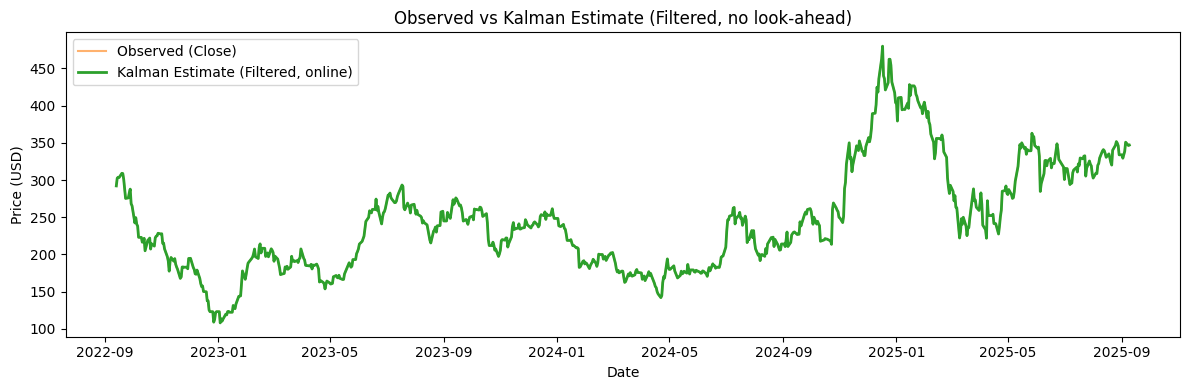

[INFO] Return model Train: 721, Test: 60
[INFO] Return SARIMAX fitted with KF-based features.
Test MAE  : 13.7492
Test RMSE : 16.8642
Test MAPE : 4.15%


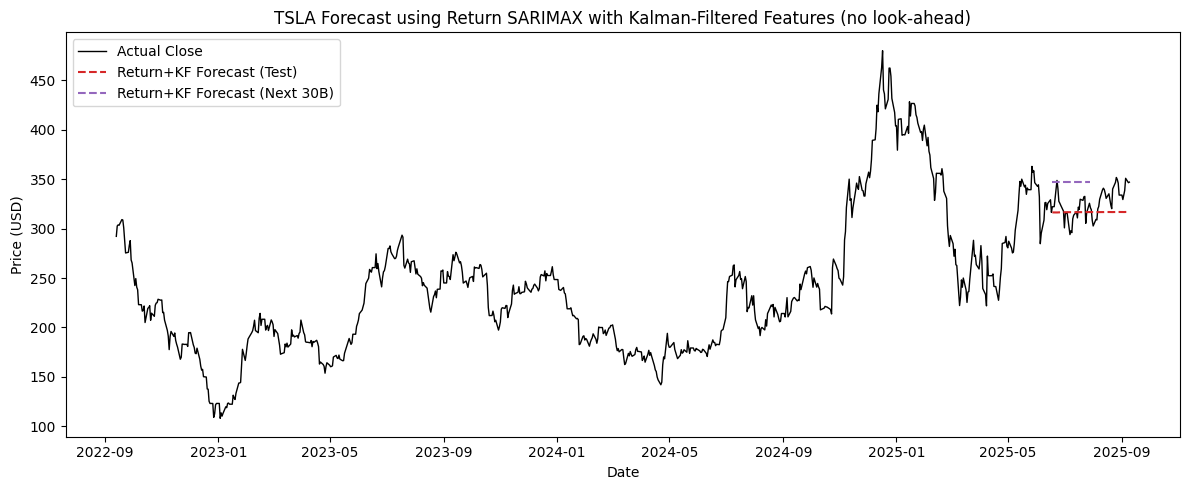

In [5]:
# -*- coding: utf-8 -*-
# -------------------------------------------------------------
# TSLA 주가 예측: Kalman Filtered Feature + Return SARIMAX
# - 주석: 한국어
# - 출력: 영어
# -------------------------------------------------------------

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# 0) 유틸 함수
# -----------------------------
def safe_download_close(ticker: str, period="3y", interval="1d"):
    """yfinance 반환 형태 변동에 안전하게 종가만 추출"""
    df = yf.download(
        ticker, period=period, interval=interval,
        group_by="column", auto_adjust=False, actions=False, progress=False
    )
    if df is None or df.empty:
        raise RuntimeError(f"yfinance returned empty data for {ticker}.")
    # Close 컬럼 탐색 (MultiIndex 방어)
    if isinstance(df.columns, pd.MultiIndex):
        flat = []
        for col in df.columns:
            name = "_".join([str(c) for c in col if c is not None])
            flat.append(name)
        df.columns = flat
        cands = [c for c in df.columns if c.lower().endswith("close")]
        if not cands:
            alt = yf.Ticker(ticker).history(period=period, interval=interval, auto_adjust=False)
            if alt is None or alt.empty or "Close" not in alt.columns:
                raise KeyError(f"Cannot find Close column for {ticker}. cols={list(df.columns)}")
            out = alt[["Close"]].copy()
        else:
            out = df.rename(columns={cands[0]: "Close"})[["Close"]].copy()
    else:
        if "Close" not in df.columns:
            alt = yf.Ticker(ticker).history(period=period, interval=interval, auto_adjust=False)
            if alt is None or alt.empty or "Close" not in alt.columns:
                raise KeyError(f"Cannot find Close column for {ticker}. cols={list(df.columns)}")
            out = alt[["Close"]].copy()
        else:
            out = df[["Close"]].copy()
    # 타임존 제거 + 정렬
    out.index = pd.to_datetime(out.index).tz_localize(None)
    out = out.sort_index().dropna()
    return out

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    eps = 1e-12
    return float(np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100.0)

def returns_to_prices(last_price: float, ret_series: pd.Series) -> pd.Series:
    """수익률 누적합을 이용해 가격으로 복원"""
    cum = ret_series.cumsum()
    prices = last_price * np.exp(cum)
    prices.name = "pred_close"
    return prices

# -----------------------------
# 1) 데이터 수집 / 빈도 부여 / 변환
# -----------------------------
# (한글) TSLA/ SPY 종가 수집
tsla = safe_download_close("TSLA", period="3y", interval="1d")
spy  = safe_download_close("SPY",  period="3y", interval="1d")

# (한글) 영업일 빈도('B') 강제 및 결측 보간
tsla = tsla.asfreq("B"); tsla["Close"] = tsla["Close"].ffill()
spy  = spy.asfreq("B");  spy["Close"]  = spy["Close"].ffill()

# (한글) 로그-변환 타깃 (UCM용): y = log(1+Close)
use_log = True
tsla["y"] = np.log1p(tsla["Close"]) if use_log else tsla["Close"]

# (한글) 로그수익률 (SARIMAX용)
tsla["ret"] = np.log(tsla["Close"]).diff()
spy["ret"]  = np.log(spy["Close"]).diff()
tsla = tsla.dropna().copy()
spy  = spy.dropna().copy()

y = tsla["y"]
close = tsla["Close"]
ret = tsla["ret"]

print(f"[INFO] Samples after align: {len(tsla)}")
print(f"[INFO] Frequency: {y.index.freqstr}")

# -----------------------------
# 2) 상태공간(UCM) 적합 → 온라인 칼만 추정치(level filtered) 산출
# -----------------------------
# (한글) 로컬 선형 추세 모델로 훈련용 구간 적합
test_size = 60
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

ucm = UnobservedComponents(
    endog=y_train,
    level='llevel',   # 로컬 레벨
    trend=True,       # 로컬 트렌드
    seasonal=None,
    freq=y_train.index.freq
)
ucm_res = ucm.fit(disp=False)
print("[INFO] UCM fitted (Kalman Filter inside).")

# (한글) 동일 모수로 전체 y(학습+테스트)에 '필터만' 재적용 (스무더 금지: 누설 방지)
ucm_res_full = ucm_res.apply(y)  # online filtering over full series

# (한글) 상태 이름에서 level 인덱스 찾기
state_names = list(ucm_res_full.model.state_names)
lvl_idx = [i for i, n in enumerate(state_names) if "level" in n.lower()]
if not lvl_idx:
    raise RuntimeError("Cannot find 'level' in state names.")
lvl_idx = lvl_idx[0]

# (한글) 온라인 필터링된 레벨 시계열 (look-ahead 없음)
level_filtered = pd.Series(
    ucm_res_full.filter_results.filtered_state[lvl_idx],
    index=y.index, name="level_filtered"
)

# (한글) 관측 스케일(USD)로 역변환 (y = log1p(Close))
if use_log:
    kf_est_price_online = np.expm1(level_filtered.values)
else:
    kf_est_price_online = level_filtered.values

# (한글) 참고용: 관측 vs 온라인 칼만 추정 겹쳐보기
plt.figure(figsize=(12,4))
plt.plot(close.index, close.values, label="Observed (Close)", color="tab:orange", alpha=0.6)
plt.plot(close.index, kf_est_price_online, label="Kalman Estimate (Filtered, online)", color="tab:green", linewidth=2)
plt.title("Observed vs Kalman Estimate (Filtered, no look-ahead)")
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# 3) 칼만 추정치로부터 특징 생성 (지연 포함, 누설 방지)
# -----------------------------
# (한글) 칼만 레벨의 변화량을 수익률 형태로 만듦
kf_level = pd.Series(kf_est_price_online, index=close.index, name="kf_price")
kf_level_ret = np.log1p(kf_level).diff()  # log1p(price) 차분

# (한글) 외생변수 프레임 구성: 칼만 파생 특징 + (선택) 시장 지수 수익률
use_spy = True
exog = pd.DataFrame(index=ret.index)
exog["kf_level_ret"] = kf_level_ret.reindex(ret.index)
if use_spy:
    exog["spy_logret"] = spy["ret"].reindex(ret.index)

# (한글) 누설 방지: 반드시 1시점 이상 지연된 특징만 사용
exog_lag1 = exog.shift(1).fillna(0.0)

# -----------------------------
# 4) 수익률 예측 모델: SARIMAX(AR(1)) + exog(kf_level_ret 등)
# -----------------------------
R_train, R_test = ret.iloc[:-test_size], ret.iloc[-test_size:]
X_train, X_test = exog_lag1.iloc[:-test_size], exog_lag1.iloc[-test_size:]

print(f"[INFO] Return model Train: {len(R_train)}, Test: {len(R_test)}")

ret_model = SARIMAX(
    endog=R_train,
    exog=X_train,
    order=(1, 0, 0),                    # AR(1)
    enforce_stationarity=True,
    enforce_invertibility=True,
    freq=R_train.index.freq
)
ret_res = ret_model.fit(disp=False)
print("[INFO] Return SARIMAX fitted with KF-based features.")

# -----------------------------
# 5) 테스트 구간 예측(수익률) → 가격 복원 → 평가
# -----------------------------
fc = ret_res.get_forecast(steps=len(R_test), exog=X_test)
ret_pred = fc.predicted_mean

last_train_price = close.reindex(R_train.index).iloc[-1]
price_pred = returns_to_prices(last_train_price, ret_pred)
price_pred.index = R_test.index

# (한글) 평가 지표
y_true = close.reindex(R_test.index).values
y_hat  = price_pred.values
mae  = mean_absolute_error(y_true, y_hat)
rmse = float(np.sqrt(mean_squared_error(y_true, y_hat)))
mape_val = mape(y_true, y_hat)

print(f"Test MAE  : {mae:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAPE : {mape_val:.2f}%")

# -----------------------------
# 6) 향후 30영업일 예측 (특징도 미래용 구성)
# -----------------------------
steps_ahead = 30
future_index = pd.date_range(start=R_test.index[-1], periods=steps_ahead+1, freq=R_train.index.freq)[1:]

# (한글) 미래 특징:
# - kf_level_ret는 관측 기반이라 미래값을 모름 → 0 가정(보수적) 또는 시나리오 가능
# - spy_logret도 미래 미지수 → 0 가정
future_exog = pd.DataFrame(index=future_index)
future_exog["kf_level_ret"] = 0.0
if use_spy:
    future_exog["spy_logret"] = 0.0

fc_future = ret_res.get_forecast(steps=steps_ahead, exog=future_exog)
ret_future = fc_future.predicted_mean

last_test_price = close.reindex(R_test.index).iloc[-1]
price_future = returns_to_prices(last_test_price, ret_future)

# -----------------------------
# 7) 시각화
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(close.index, close.values, label="Actual Close", color="black", linewidth=1)

# 테스트 구간 예측(가격)
plt.plot(price_pred.index, price_pred.values, "--", label="Return+KF Forecast (Test)", color="tab:red")

# 향후 30영업일 예측(가격)
plt.plot(price_future.index, price_future.values, "--", label="Return+KF Forecast (Next 30B)", color="tab:purple")

plt.title("TSLA Forecast using Return SARIMAX with Kalman-Filtered Features (no look-ahead)")
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.legend(); plt.tight_layout(); plt.show()


# TSLA 일별 종가로 “원데이터 vs 칼만필터 전처리 데이터” 각각 LSTM을 학습하고, 동일한 테스트 구간에서 성능을 비교

[INFO] Loaded TSLA: 782 rows, freq=B
[INFO] UCM fitted for Kalman preprocessing.
[INFO] Raw train/test seq: 692/60
[INFO] KF  train/test seq: 692/60
[INFO] Raw LSTM best val_loss: 0.001552
[INFO] KF  LSTM best val_loss: 0.001631
Raw-LSTM      MAE : 6.6862
Raw-LSTM      RMSE: 9.1455
Raw-LSTM      MAPE: 2.07%
Kalman-LSTM   MAE : 7.0306
Kalman-LSTM   RMSE: 9.4289
Kalman-LSTM   MAPE: 2.18%


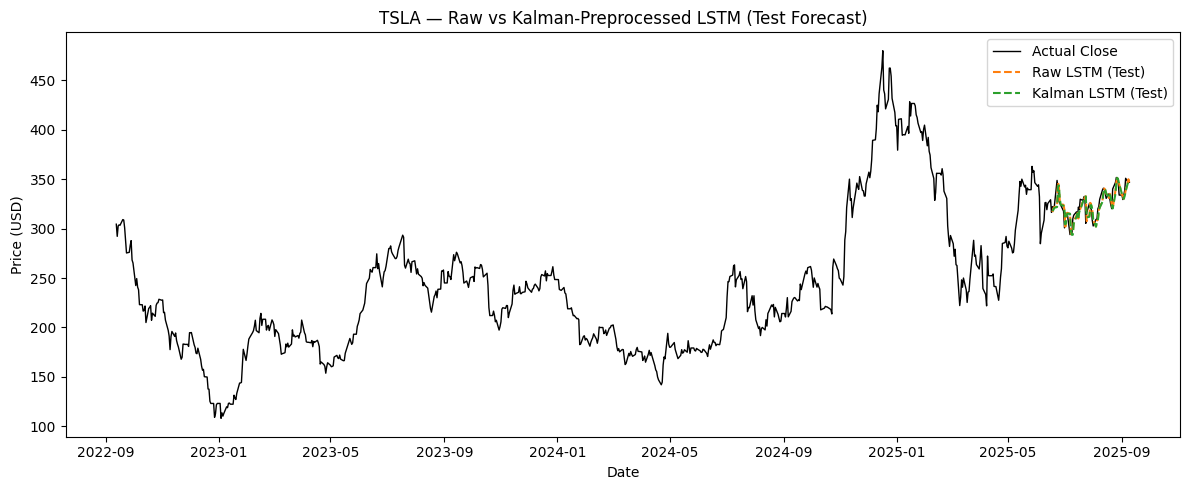

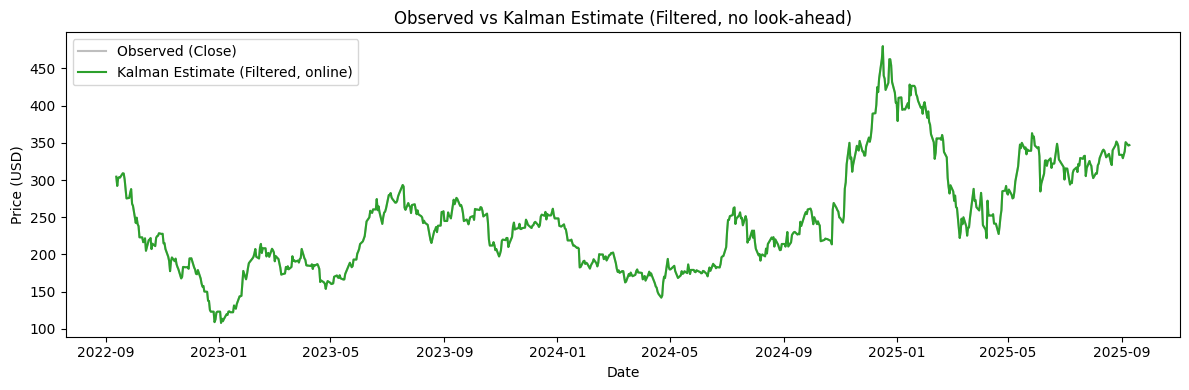

In [6]:
# -*- coding: utf-8 -*-
# -------------------------------------------------------------
# TSLA 주가예측: 원데이터 vs 칼만필터 전처리 → 각각 LSTM 학습 성능 비교
# - 주석: 한국어
# - 출력: 영어
# -------------------------------------------------------------

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

# TensorFlow/Keras
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 수집/칼만필터
import yfinance as yf
from statsmodels.tsa.statespace.structural import UnobservedComponents

# 평가/스케일
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# 0) 유틸 함수
# -----------------------------
def download_close(ticker="TSLA", period="3y", interval="1d"):
    """yfinance에서 종가만 안전하게 가져오기(MultiIndex 방어)"""
    df = yf.download(ticker, period=period, interval=interval,
                     group_by="column", auto_adjust=False, actions=False, progress=False)
    if df is None or df.empty:
        raise RuntimeError(f"Empty data for {ticker}")
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ["_".join([str(c) for c in col if c is not None]) for col in df.columns]
        cand = [c for c in df.columns if c.lower().endswith("close")]
        if not cand:
            alt = yf.Ticker(ticker).history(period=period, interval=interval, auto_adjust=False)
            out = alt[["Close"]].copy()
        else:
            out = df.rename(columns={cand[0]: "Close"})[["Close"]].copy()
    else:
        out = df[["Close"]].copy() if "Close" in df.columns else yf.Ticker(ticker).history(period=period, interval=interval)[["Close"]].copy()
    out.index = pd.to_datetime(out.index).tz_localize(None)
    out = out.sort_index().dropna()
    # 영업일 빈도로 맞추고 결측 전방채움
    out = out.asfreq("B")
    out["Close"] = out["Close"].ffill()
    return out

def create_sequences(series_values, look_back, index_like=None):
    """단일 시계열로 (X, y) 시퀀스 생성. index_like가 있으면 y의 인덱스 반환."""
    X, y, y_idx = [], [], []
    for i in range(len(series_values) - look_back):
        X.append(series_values[i:i+look_back])
        y.append(series_values[i+look_back])
        if index_like is not None:
            y_idx.append(index_like[i+look_back])
    X = np.array(X)[:, :, None]  # (samples, timesteps, features=1)
    y = np.array(y)
    return (X, y, np.array(y_idx) if index_like is not None else None)

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    eps = 1e-12
    return float(np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100.0)

def build_lstm(input_len):
    """심플 LSTM 회귀 모델"""
    model = Sequential([
        LSTM(64, input_shape=(input_len, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# -----------------------------
# 1) 데이터 수집
# -----------------------------
df = download_close("TSLA", period="3y", interval="1d")
price = df["Close"].copy()
print(f"[INFO] Loaded TSLA: {len(price)} rows, freq={price.index.freqstr}")

# -----------------------------
# 2) 칼만필터 전처리 (online filtering, look-ahead 방지)
#    - UCM(local linear trend)을 학습 구간에 적합 후 전체 시계열에 apply
# -----------------------------
test_size = 60               # 마지막 60 영업일을 테스트로
look_back = 30               # LSTM 입력 윈도우 길이
y_log = np.log1p(price)      # 관측식 안정화를 위해 log1p 사용
y_train, y_test = y_log.iloc[:-test_size], y_log.iloc[-test_size:]

ucm = UnobservedComponents(endog=y_train, level="llevel", trend=True, seasonal=None, freq=y_train.index.freq)
ucm_res = ucm.fit(disp=False)
print("[INFO] UCM fitted for Kalman preprocessing.")

# 전체 구간에 '필터만' 적용(평활 X) → online filtered level
ucm_res_full = ucm_res.apply(y_log)
state_names = list(ucm_res_full.model.state_names)
lvl_idx = [i for i, n in enumerate(state_names) if "level" in n.lower()][0]
level_filtered = pd.Series(ucm_res_full.filter_results.filtered_state[lvl_idx], index=y_log.index, name="level_filtered")

# 칼만 전처리 시계열을 가격 스케일로 역변환
price_kf = np.expm1(level_filtered)

# -----------------------------
# 3) 스케일링(학습 구간에만 적합) → 시퀀스 생성
# -----------------------------
# (a) 원데이터 파이프라인
sc_raw = MinMaxScaler()
raw_train_values = sc_raw.fit_transform(price.iloc[:-test_size].values.reshape(-1,1)).ravel()
raw_all_values   = np.concatenate([raw_train_values,
                                   sc_raw.transform(price.iloc[-test_size:].values.reshape(-1,1)).ravel()])

X_raw, y_raw, idx_raw = create_sequences(raw_all_values, look_back, index_like=price.index)
# y_raw/idx_raw는 전체 윈도우에 해당 → 테스트 마스크 생성
test_mask = idx_raw >= price.index[-test_size:] [0]   # y 인덱스가 테스트 시작일 이상인 위치
X_raw_train, y_raw_train = X_raw[~test_mask], y_raw[~test_mask]
X_raw_test,  y_raw_test  = X_raw[test_mask],  y_raw[test_mask]
idx_raw_test = idx_raw[test_mask]

# (b) 칼만 전처리 파이프라인
sc_kf = MinMaxScaler()
kf_train_values = sc_kf.fit_transform(price_kf.iloc[:-test_size].values.reshape(-1,1)).ravel()
kf_all_values   = np.concatenate([kf_train_values,
                                  sc_kf.transform(price_kf.iloc[-test_size:].values.reshape(-1,1)).ravel()])

X_kf, y_kf, idx_kf = create_sequences(kf_all_values, look_back, index_like=price.index)
test_mask_kf = idx_kf >= price.index[-test_size:] [0]
X_kf_train, y_kf_train = X_kf[~test_mask_kf], y_kf[~test_mask_kf]
X_kf_test,  y_kf_test  = X_kf[test_mask_kf],  y_kf[test_mask_kf]
idx_kf_test = idx_kf[test_mask_kf]

print(f"[INFO] Raw train/test seq: {X_raw_train.shape[0]}/{X_raw_test.shape[0]}")
print(f"[INFO] KF  train/test seq: {X_kf_train.shape[0]}/{X_kf_test.shape[0]}")

# -----------------------------
# 4) 모델 학습 (원데이터 vs 칼만 전처리)
# -----------------------------
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# 원데이터 LSTM
model_raw = build_lstm(look_back)
hist_raw = model_raw.fit(
    X_raw_train, y_raw_train,
    validation_split=0.2,
    epochs=200, batch_size=32, verbose=0, callbacks=[es]
)
print(f"[INFO] Raw LSTM best val_loss: {min(hist_raw.history['val_loss']):.6f}")

# 칼만 전처리 LSTM
model_kf = build_lstm(look_back)
hist_kf = model_kf.fit(
    X_kf_train, y_kf_train,
    validation_split=0.2,
    epochs=200, batch_size=32, verbose=0, callbacks=[es]
)
print(f"[INFO] KF  LSTM best val_loss: {min(hist_kf.history['val_loss']):.6f}")

# -----------------------------
# 5) 예측/역스케일 → 평가
# -----------------------------
# 예측(스케일 공간)
pred_raw_scaled = model_raw.predict(X_raw_test, verbose=0).ravel()
pred_kf_scaled  = model_kf.predict(X_kf_test,  verbose=0).ravel()

# 역스케일
pred_raw = sc_raw.inverse_transform(pred_raw_scaled.reshape(-1,1)).ravel()
pred_kf  = sc_kf.inverse_transform(pred_kf_scaled.reshape(-1,1)).ravel()

# 테스트 실제 y도 역스케일
true_raw = sc_raw.inverse_transform(y_raw_test.reshape(-1,1)).ravel()
true_kf  = sc_kf.inverse_transform(y_kf_test.reshape(-1,1)).ravel()

# 동일한 실제 가격(원 시계열) 기준으로 평가(두 파이프라인 모두 같은 날짜 집합)
#  → idx_raw_test == idx_kf_test 를 가정 (동일 split 설정)
assert np.all(idx_raw_test == idx_kf_test), "Test indices misaligned."
true_price = price.reindex(idx_raw_test).values  # 원 스케일 정답

# 이미 true_raw/true_kf도 같은 true_price에 근접해야 하지만, 안전하게 동일 y로 평가
def print_scores(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mp = mape(y_true, y_pred)
    print(f"{name}  MAE : {mae:.4f}")
    print(f"{name}  RMSE: {rmse:.4f}")
    print(f"{name}  MAPE: {mp:.2f}%")

print_scores("Raw-LSTM    ", true_price, pred_raw)
print_scores("Kalman-LSTM ", true_price, pred_kf)

# -----------------------------
# 6) 시각화 비교
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(price.index, price.values, label="Actual Close", color="black", linewidth=1)
plt.plot(idx_raw_test, pred_raw, "--", label="Raw LSTM (Test)", color="tab:orange")
plt.plot(idx_kf_test, pred_kf, "--", label="Kalman LSTM (Test)", color="tab:green")
plt.title("TSLA — Raw vs Kalman-Preprocessed LSTM (Test Forecast)")
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# 7) Kalman Estimate 시각화(참고)
# -----------------------------
plt.figure(figsize=(12,4))
plt.plot(price.index, price.values, label="Observed (Close)", color="tab:gray", alpha=0.5)
plt.plot(price_kf.index, price_kf.values, label="Kalman Estimate (Filtered, online)", color="tab:green")
plt.title("Observed vs Kalman Estimate (Filtered, no look-ahead)")
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.legend(); plt.tight_layout(); plt.show()
